# Danh sách thành viên:
* 20521517 - Nguyễn Thành Lâm
* 20521384 - Hoàng Đình Hữu 
* 20521467 - Lê Văn Khoa 
* 20521482 - Trần Đình Khôi
* 20521493 - Bùi Tuấn Kiệt

In [ ]:
%matplotlib inline

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")


from sklearn import tree
from sklearn.linear_model import Ridge, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab/Data_mining_Project/flights.csv')

In [ ]:
airlines_names = pd.read_csv('/content/drive/MyDrive/Colab/Data_mining_Project/airlines.csv')
airports = pd.read_csv('/content/drive/MyDrive/Colab/Data_mining_Project/airports.csv')

# Preprocessing data

Contribute YEAR, MONTH, DAY to DATE

In [ ]:
df = df[df['MONTH'] == 1]

In [ ]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

In [ ]:
df['DATE']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2015-01-01
4        2015-01-01
            ...    
469963   2015-01-31
469964   2015-01-31
469965   2015-01-31
469966   2015-01-31
469967   2015-01-31
Name: DATE, Length: 469968, dtype: datetime64[ns]

In [ ]:
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [ ]:
#Datatime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

Convert datatime

In [ ]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


** Comment: DEPARTURE_TIME and ARRIVAL_TIME may be not useful to data frame because two attributes DEPARTURE_DELAY and ARRIVAL_DELAY (CHƯA XONG) **

## Những cột cần loại bỏ

In [ ]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


# Check missing data in data frame

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


In [ ]:
df.dropna(inplace = True)

# Comparing airlines

In [ ]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [ ]:
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

In [ ]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


# Graph 1

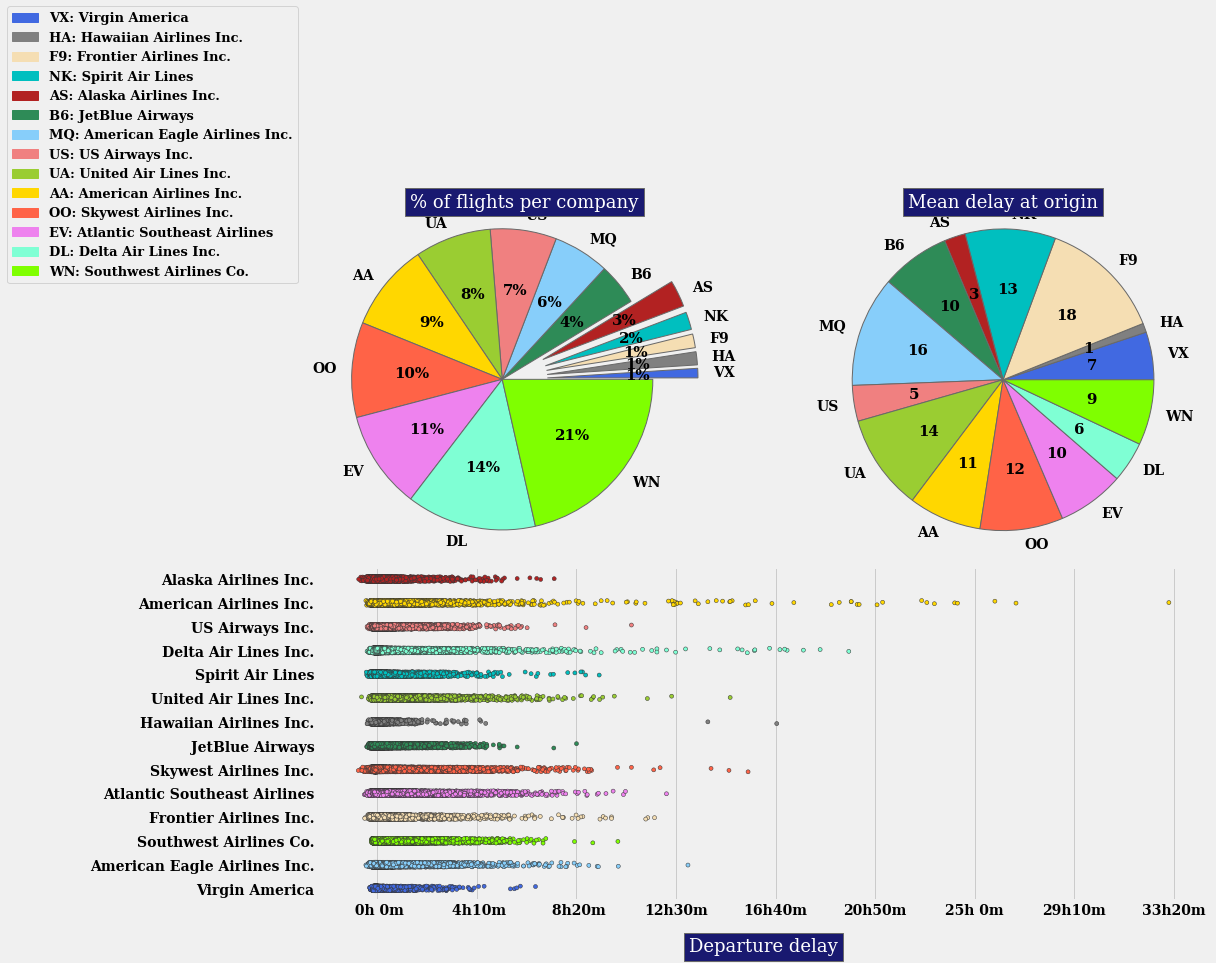

In [ ]:
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

# Graph 2

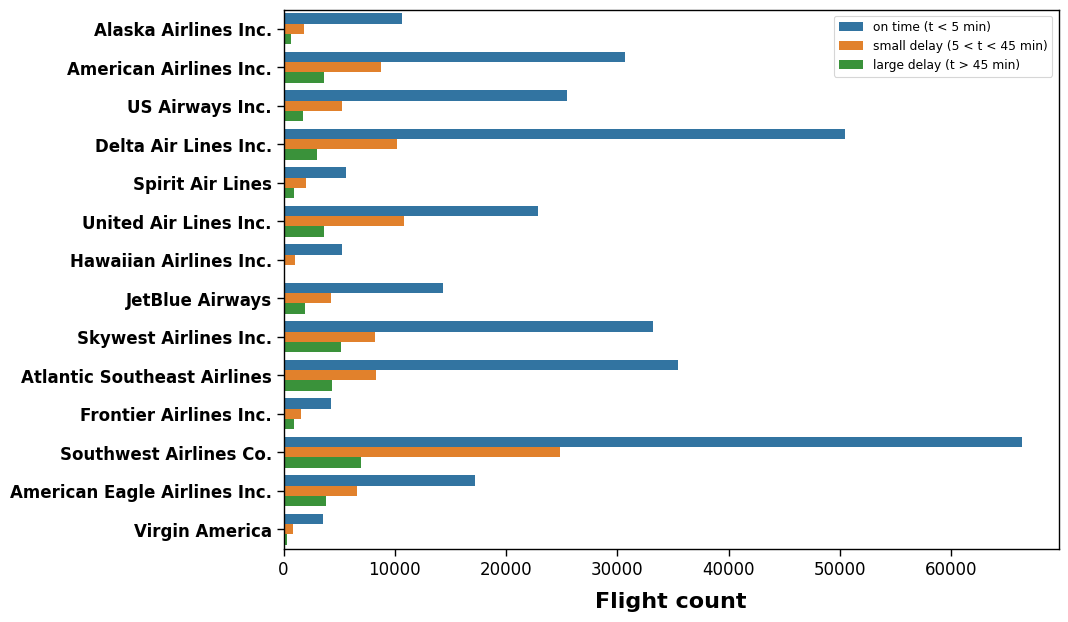

In [ ]:
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

# Graph 3

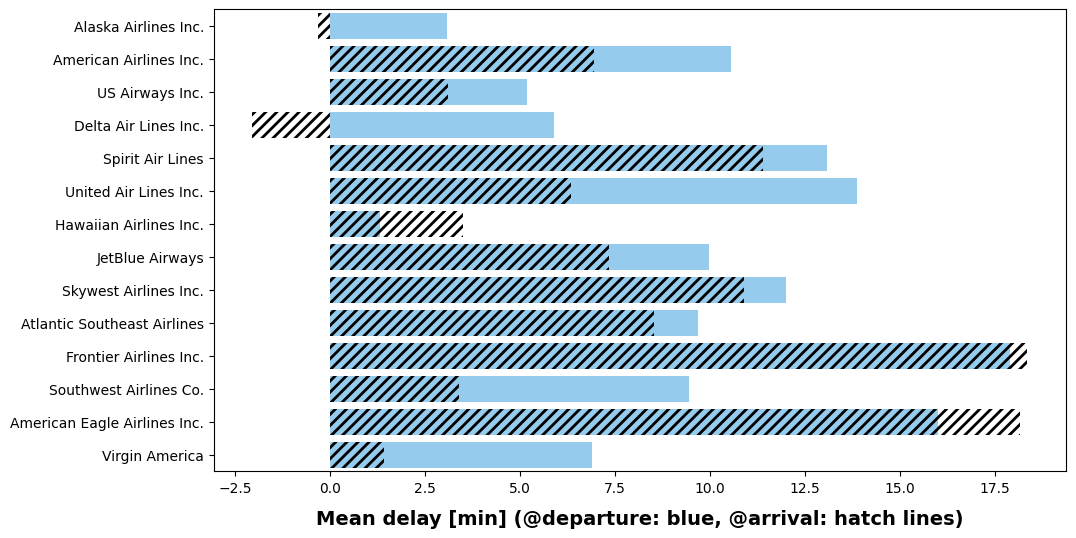

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

# Graph 4

In [ ]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
    
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(15,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='serif',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)    
plt.tight_layout()

## Graph 4.1 

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)

#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

# Predicting flight delays

# Train test

In [ ]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]

# Model: Accounting for destination

In [ ]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [ ]:
carrier = 'AA'
df3 = create_df(df_train, carrier)
df3['Delay'] = (df3['DEPARTURE_DELAY'] > 5).astype(int)
df3

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday,Delay
0,300,17640,LAX,2.133333,2.800000,0
1,300,17700,LAX,5.500000,3.750000,1
2,600,28200,LAX,-6.000000,3.250000,0
3,1200,29040,LAX,-4.117647,2.823529,0
4,1200,29100,LAX,0.800000,3.600000,0
...,...,...,...,...,...,...
3099,85800,28800,SFO,6.062500,2.625000,1
3100,85800,29100,SFO,9.750000,3.750000,1
3101,86040,21000,LAX,3.437500,2.625000,0
3102,86100,21000,LAX,-1.000000,3.600000,0


In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
X = np.array(df3[['heure_depart', 'heure_arrivee']])
scaler = StandardScaler()
X = np.hstack((onehot_encoded, X))
Y = np.array(df3['Delay'])
Y = Y.reshape(len(Y), 1)

In [ ]:
np.random.seed(1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
df3_test = create_df(df_test, carrier)
df3_test['Delay'] = (df3_test['DEPARTURE_DELAY'] > 5).astype(int)    
df3_test[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT,DEPARTURE_DELAY,weekday,Delay
0,300,17640,LAX,-4.000,3.25,0
1,1200,29040,LAX,5.125,3.25,1
2,1800,20340,SFO,-6.750,3.25,0
3,2700,29340,LAS,-4.500,3.25,0
4,3900,31800,LAX,-4.875,3.25,0


In [ ]:
label_conversion1 = dict()
for s in label_airports:
    label_conversion1[s[1]] = s[0]

df3_test['ORIGIN_AIRPORT'].replace(label_conversion1, inplace = True)

for index, label in label_airports:
    temp1 = df3_test['ORIGIN_AIRPORT'] == index
    temp1 = temp1.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix1 = np.array(temp1)
    else:
        matrix1 = np.vstack((matrix1, temp1))
matrix1 = matrix1.T


b_test = np.array(df3_test[['heure_depart', 'heure_arrivee']])
X_df_test = np.hstack((matrix1, b_test))
Y_df_test = np.array(df3_test['Delay'])
Y_df_test = Y_df_test.reshape(len(Y_df_test), 1)

X_df_test = scaler.fit_transform(X_df_test)

## Hữu(Random forest, AdaBoost classifer)




* Random forest

In [ ]:
def draw_cfsmatrix(pred,score,Y_test,name):
  model = metrics.confusion_matrix(Y_test, pred)
  plt.figure(figsize=(8,8))
  sns.heatmap(model, annot=True, fmt=".0f", linewidths=.5, square = True, cmap= 'Blues_r');
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  title = (name +' Accuracy Score: {0}').format(round(score*100))
  plt.title(title, size = 15)

Random Forest
Accuracy score: 0.6062231759656652
Time: 0.45551419258117676


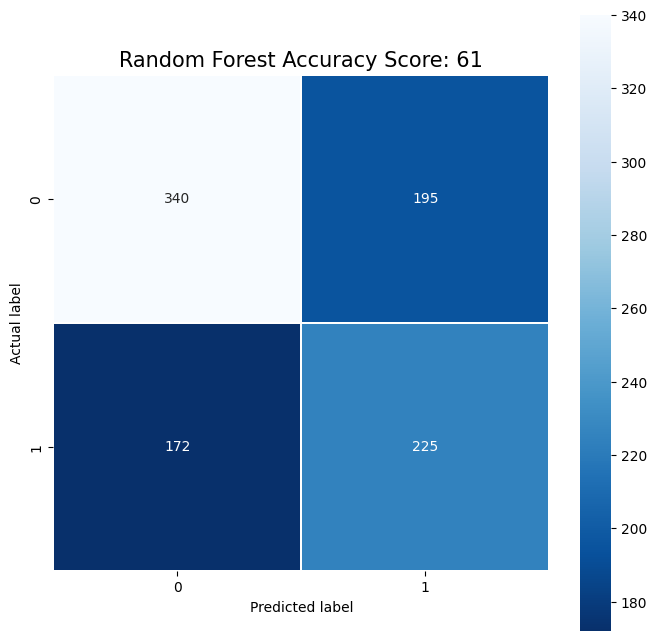

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
start = time.time()
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)
end = time.time()
rf_pred = rf_model.predict(X_test)
rf_score = metrics.accuracy_score(Y_test,rf_pred)
print('Random Forest')
print('Accuracy score:',rf_score)
print('Time:',end-start)
draw_cfsmatrix(rf_pred,rf_score,Y_test,'Random Forest')

In [ ]:
print("Report:\n",metrics.classification_report(Y_test, rf_pred))

Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65       535
           1       0.54      0.57      0.55       397

    accuracy                           0.61       932
   macro avg       0.60      0.60      0.60       932
weighted avg       0.61      0.61      0.61       932



***df_test***

Accuracy score: 0.6438356164383562


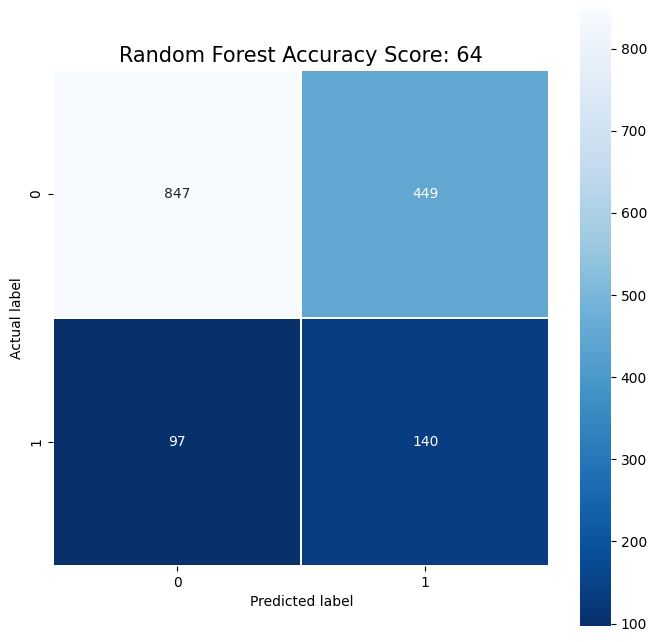

In [ ]:
rf_pred_test = rf_model.predict(X_df_test)
rf_score_test = metrics.accuracy_score(Y_df_test,rf_pred_test)
print('Accuracy score:',rf_score_test)
draw_cfsmatrix(rf_pred_test,rf_score_test,Y_df_test,'Random Forest')

In [ ]:
print("Report:\n",metrics.classification_report(Y_df_test, rf_pred_test))

Report:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76      1296
           1       0.24      0.59      0.34       237

    accuracy                           0.64      1533
   macro avg       0.57      0.62      0.55      1533
weighted avg       0.80      0.64      0.69      1533



* AdaBoost Classifer

AdaBoost Classifier
Accuracy score: 0.6781115879828327
Time: 0.19656872749328613


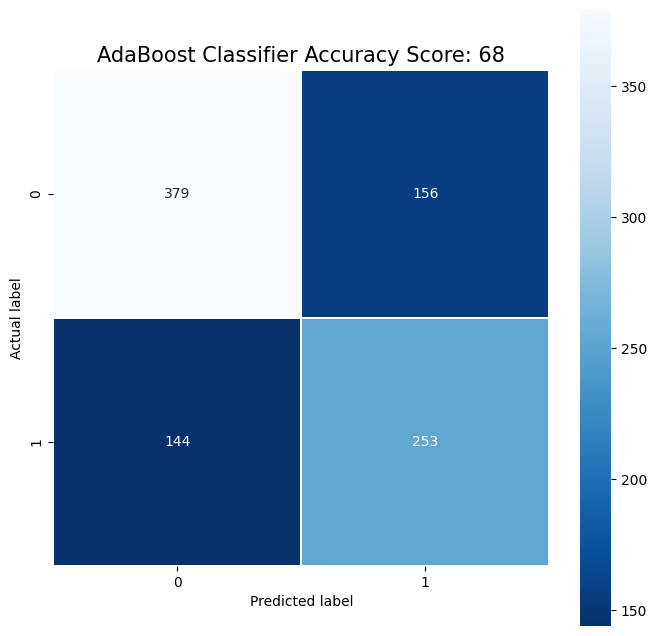

In [ ]:
from sklearn.ensemble import AdaBoostClassifier 
start = time.time()
rc_model = AdaBoostClassifier(random_state=42)
rc_model.fit(X_train, Y_train)
end = time.time()
rc_pred = rc_model.predict(X_test)
rc_score = metrics.accuracy_score(Y_test,rc_pred)
print('AdaBoost Classifier')
print('Accuracy score:',rc_score)
print('Time:',end-start)
draw_cfsmatrix(rc_pred,rc_score,Y_test,'AdaBoost Classifier')

In [ ]:
print("Report:\n",metrics.classification_report(Y_test, rc_pred))

Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       535
           1       0.62      0.64      0.63       397

    accuracy                           0.68       932
   macro avg       0.67      0.67      0.67       932
weighted avg       0.68      0.68      0.68       932



***df_test***

Accuracy score: 0.5877364644487932


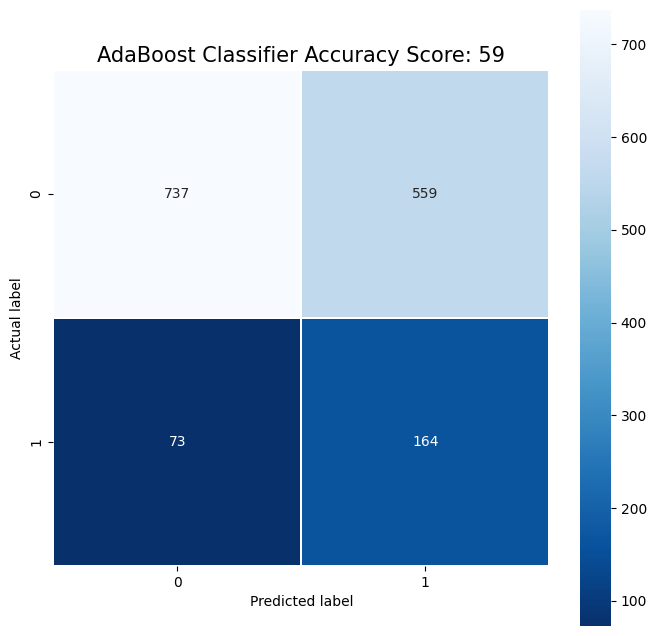

In [ ]:
rc_pred_test = rc_model.predict(X_df_test)
rc_score_test = metrics.accuracy_score(Y_df_test,rc_pred_test)
print('Accuracy score:',rc_score_test)
draw_cfsmatrix(rc_pred_test,rc_score_test,Y_df_test,'AdaBoost Classifier')

In [ ]:
print("Report:\n",metrics.classification_report(Y_df_test, rc_pred_test))

Report:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70      1296
           1       0.23      0.69      0.34       237

    accuracy                           0.59      1533
   macro avg       0.57      0.63      0.52      1533
weighted avg       0.80      0.59      0.64      1533



## Khoa(Bagging classifer, Decision tree)

* Bagging classifer

In [ ]:
start = time.time()
bc = BaggingClassifier(random_state = 42)
# poly_bc = PolynomialFeatures(degree = 1)
# X_bc = poly_bc.fit_transform(X_train)
bc.fit(X_train , Y_train)
end = time.time()

# X_bc = poly_bc.fit_transform(X_test)
result_bc = bc.predict(X_test)
score_bc = metrics.accuracy_score(Y_test,result_bc)        
print("Accruracy:",score_bc)
print("Report:\n",metrics.classification_report(Y_test,result_bc))

Accruracy: 0.5901287553648069
Report:
               precision    recall  f1-score   support

           0       0.64      0.67      0.65       535
           1       0.52      0.49      0.50       397

    accuracy                           0.59       932
   macro avg       0.58      0.58      0.58       932
weighted avg       0.59      0.59      0.59       932



In [ ]:
print('Thời gian thực thi với thuật toán Bagging Classifier:', end - start)

Thời gian thực thi với thuật toán Bagging Classifier: 0.11828303337097168


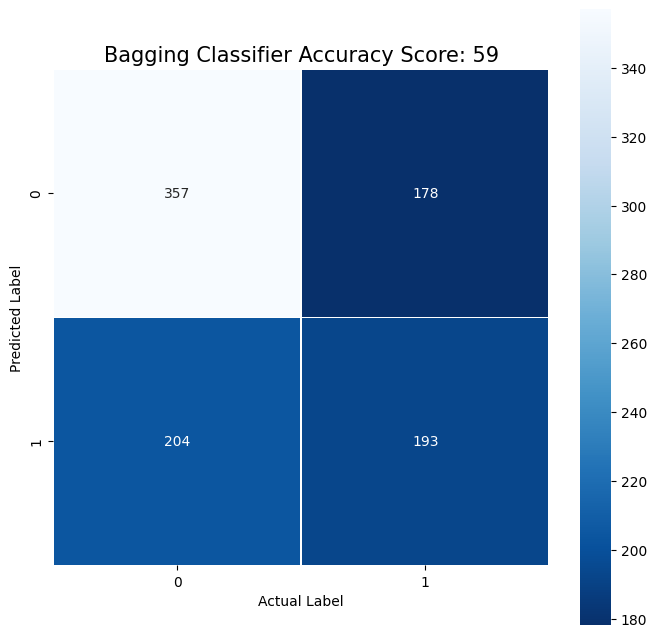

In [ ]:
bc_cm = metrics.confusion_matrix(Y_test,result_bc)
plt.figure(figsize=(8,8))
sns.heatmap(bc_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Bagging Classifier Accuracy Score:{0}'.format(" "+str(round(score_bc*100)))
plt.title(title,size=15);

***Df_test***

In [ ]:
# X_bc = poly_bc.fit_transform(X_df_test)
result_bc = bc.predict(X_df_test)
score_bc = metrics.accuracy_score(Y_df_test,result_bc)        
print('Accuracy score = {}'.format(score_bc))  
print("Report:\n",metrics.classification_report(Y_df_test,result_bc))

Accuracy score = 0.6503587736464449
Report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.76      1296
           1       0.23      0.54      0.32       237

    accuracy                           0.65      1533
   macro avg       0.56      0.61      0.54      1533
weighted avg       0.79      0.65      0.70      1533



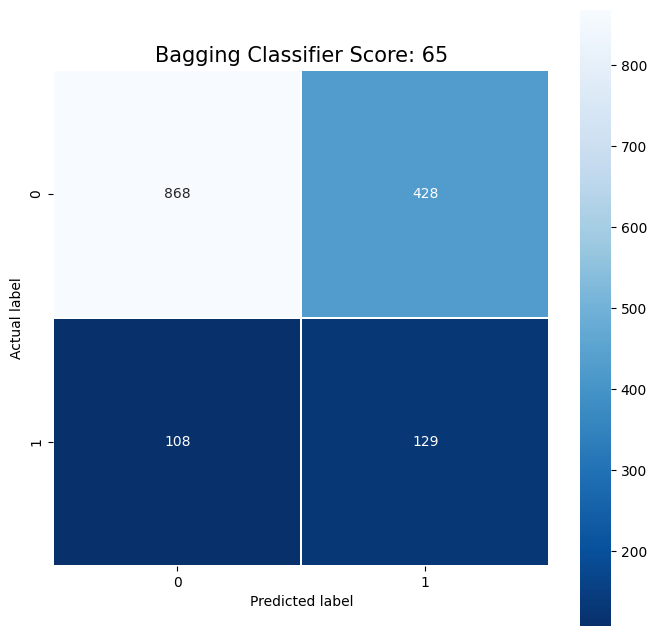

In [ ]:
cm_bc = metrics.confusion_matrix(Y_df_test,result_bc)

plt.figure(figsize=(8,8))
sns.heatmap(cm_bc, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Bagging Classifier Score: {0}'.format(round(score_bc*100))
plt.title(title,size=15);

* Decision tree

In [ ]:
start = time.time()
dt = tree.DecisionTreeClassifier(criterion="entropy",random_state=42)
poly_dt = PolynomialFeatures(degree = 1)
  
X_dt = poly_dt.fit_transform(X_train)
dt.fit(X_dt, Y_train)
end = time.time()

X_dt = poly_dt.fit_transform(X_test)
result_dt = dt.predict(X_dt)

tree_score = metrics.accuracy_score(Y_test,result_dt)
print("Accruracy:",tree_score)
print("Report:\n",metrics.classification_report(Y_test,result_dt))

Accruracy: 0.5869098712446352
Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64       535
           1       0.51      0.53      0.52       397

    accuracy                           0.59       932
   macro avg       0.58      0.58      0.58       932
weighted avg       0.59      0.59      0.59       932



In [ ]:
print('Thời gian thực thi với thuật toán Decision Tree:', end - start)

Thời gian thực thi với thuật toán Decision Tree: 0.02712106704711914


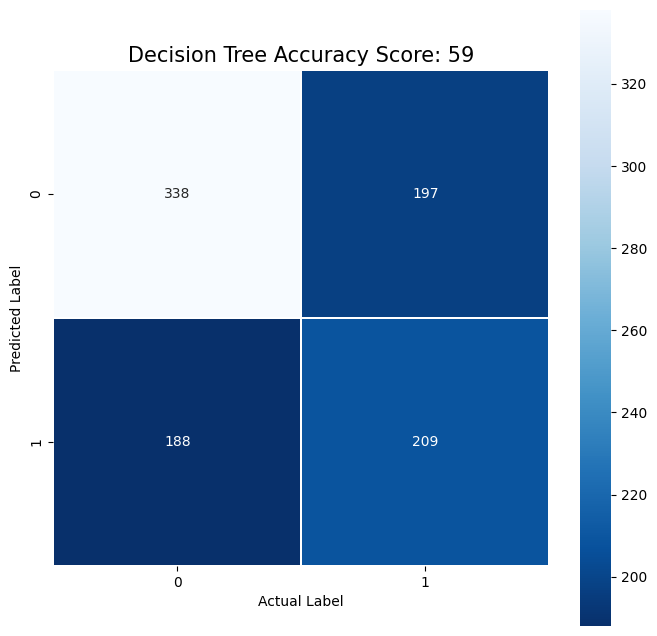

In [ ]:
tree_cm = metrics.confusion_matrix(Y_test,result_dt)
plt.figure(figsize=(8,8))
sns.heatmap(tree_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Decision Tree Accuracy Score:{0}'.format(" "+str(round(tree_score*100)))
plt.title(title,size=15);

***df_test***

In [ ]:
X_dt = poly_dt.fit_transform(X_df_test)
result_dt = dt.predict(X_dt)
score_dt = metrics.accuracy_score(Y_df_test,result_dt)        
print('Accuracy score = {}'.format(score_dt))  
print("Report:\n",metrics.classification_report(Y_df_test,result_dt))

Accuracy score = 0.6327462491846053
Report:
               precision    recall  f1-score   support

           0       0.89      0.65      0.75      1296
           1       0.22      0.55      0.32       237

    accuracy                           0.63      1533
   macro avg       0.56      0.60      0.53      1533
weighted avg       0.79      0.63      0.68      1533



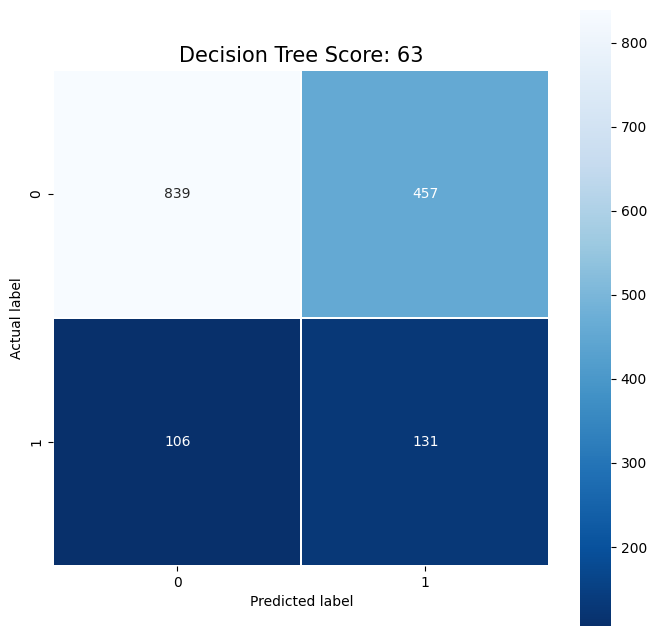

In [ ]:
cm_dt = metrics.confusion_matrix(Y_df_test,result_dt)

plt.figure(figsize=(8,8))
sns.heatmap(cm_dt, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Decision Tree Score: {0}'.format(round(score_dt*100))
plt.title(title,size=15);

## Khôi(Navie Bayes, K-Nearest Neighboor)

* Navie Bayes

In [ ]:
start = time.time()
bnl = BernoulliNB(alpha=2)
poly_bnl = PolynomialFeatures(degree = 1)
X_bnl = poly_bnl.fit_transform(X_train)
bnl.fit(X_bnl , Y_train)
end = time.time()

X_bnl = poly_bnl.fit_transform(X_test)
result_bnl = bnl.predict(X_bnl)
score_bnl = metrics.accuracy_score(Y_test,result_bnl)        
print("Accruracy:",score_bnl)
print("Report:\n",metrics.classification_report(Y_test,result_bnl))

Accruracy: 0.6791845493562232
Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       535
           1       0.63      0.60      0.61       397

    accuracy                           0.68       932
   macro avg       0.67      0.67      0.67       932
weighted avg       0.68      0.68      0.68       932



In [ ]:
print('Thời gian thực thi với thuật toán Navie Bayes:', end - start)

Thời gian thực thi với thuật toán Navie Bayes: 0.009204626083374023


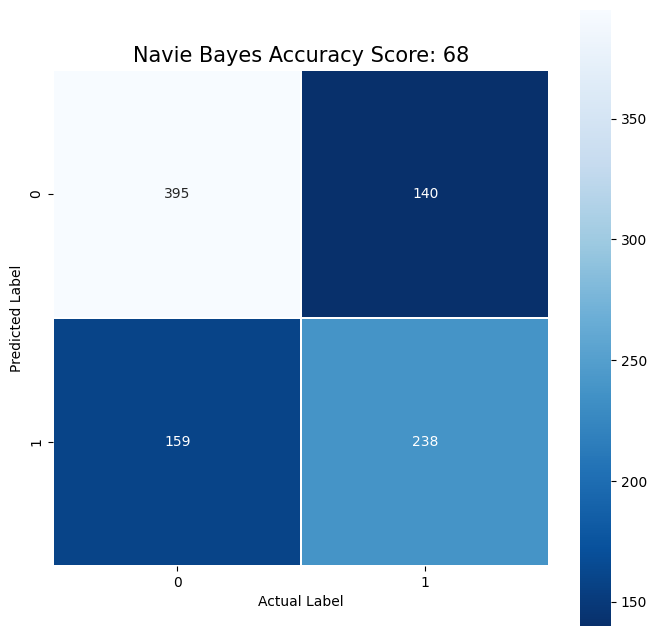

In [ ]:
bnl_cm = metrics.confusion_matrix(Y_test,result_bnl)
plt.figure(figsize=(8,8))
sns.heatmap(bnl_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Navie Bayes Accuracy Score:{0}'.format(" "+str(round(score_bnl*100)))
plt.title(title,size=15);

***df_test***

In [ ]:
X_bnl = poly_bnl.fit_transform(X_df_test)
result_bnl = bnl.predict(X_bnl)
score_bnl = metrics.accuracy_score(Y_df_test,result_bnl)        
print('Accuracy score = {}'.format(score_bnl))  
print("Report:\n",metrics.classification_report(Y_df_test,result_bnl))

Accuracy score = 0.6223091976516634
Report:
               precision    recall  f1-score   support

           0       0.91      0.61      0.73      1296
           1       0.24      0.67      0.35       237

    accuracy                           0.62      1533
   macro avg       0.57      0.64      0.54      1533
weighted avg       0.81      0.62      0.67      1533



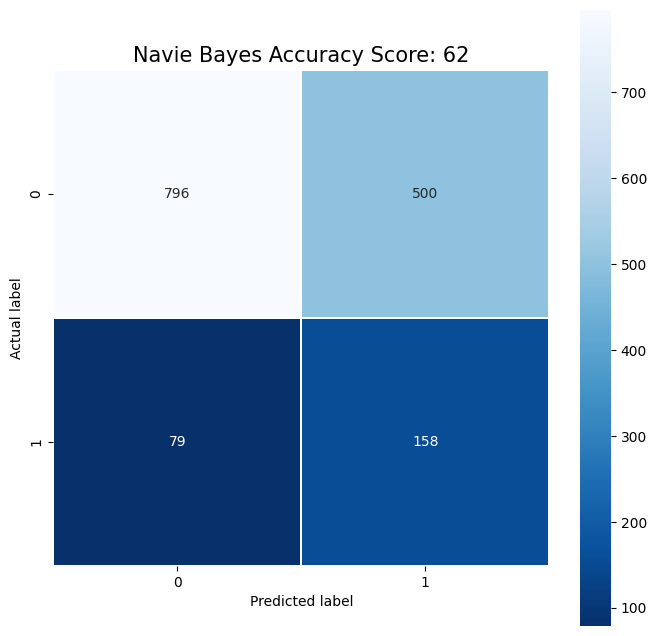

In [ ]:
cm_bnl = metrics.confusion_matrix(Y_df_test,result_bnl)

plt.figure(figsize=(8,8))
sns.heatmap(cm_bnl, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Navie Bayes Accuracy Score: {0}'.format(round(score_bnl*100))
plt.title(title,size=15);

* K-Nearest Neighboor

In [ ]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=2)
poly_knn = PolynomialFeatures(degree = 1)
X_knn = poly_knn.fit_transform(X_train)
knn.fit(X_knn , Y_train)
end = time.time()

X_knn = poly_knn.fit_transform(X_test)
result_knn = knn.predict(X_knn)
score_knn = metrics.accuracy_score(Y_test,result_knn)        
print("Accruracy:",score_knn)
print("Report:\n",metrics.classification_report(Y_test,result_knn))

Accruracy: 0.6148068669527897
Report:
               precision    recall  f1-score   support

           0       0.63      0.80      0.71       535
           1       0.58      0.36      0.45       397

    accuracy                           0.61       932
   macro avg       0.60      0.58      0.58       932
weighted avg       0.61      0.61      0.59       932



In [ ]:
print('Thời gian thực thi với thuật toán KNN:', end - start)

Thời gian thực thi với thuật toán KNN: 0.004407644271850586


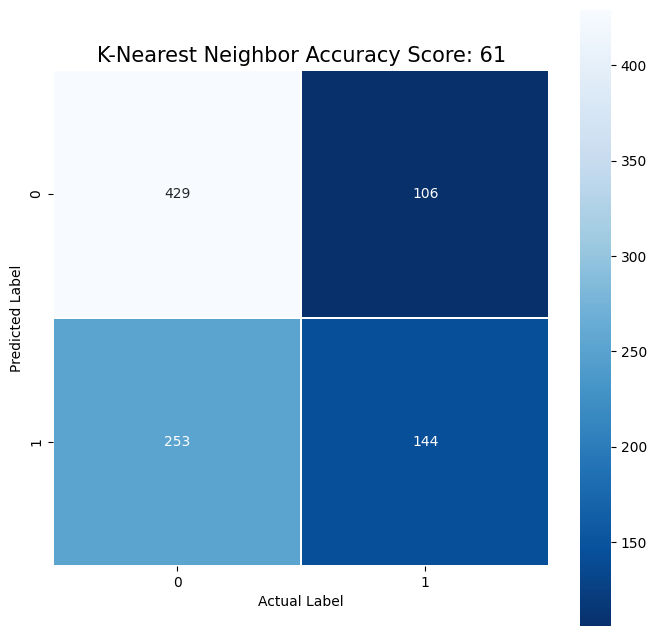

In [ ]:
knn_cm = metrics.confusion_matrix(Y_test,result_knn)
plt.figure(figsize=(8,8))
sns.heatmap(knn_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='K-Nearest Neighbor Accuracy Score:{0}'.format(" "+str(round(score_knn*100)))
plt.title(title,size=15);
plt.show();

***df_test***

In [ ]:
X_knn = poly_knn.fit_transform(X_df_test)
result_knn = knn.predict(X_knn)
score_knn = metrics.accuracy_score(Y_df_test,result_knn)        
print('Accuracy score = {}'.format(score_knn))  
print("Report:\n",metrics.classification_report(Y_df_test,result_knn))

Accuracy score = 0.7195042400521853
Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1296
           1       0.24      0.38      0.30       237

    accuracy                           0.72      1533
   macro avg       0.56      0.58      0.56      1533
weighted avg       0.78      0.72      0.74      1533



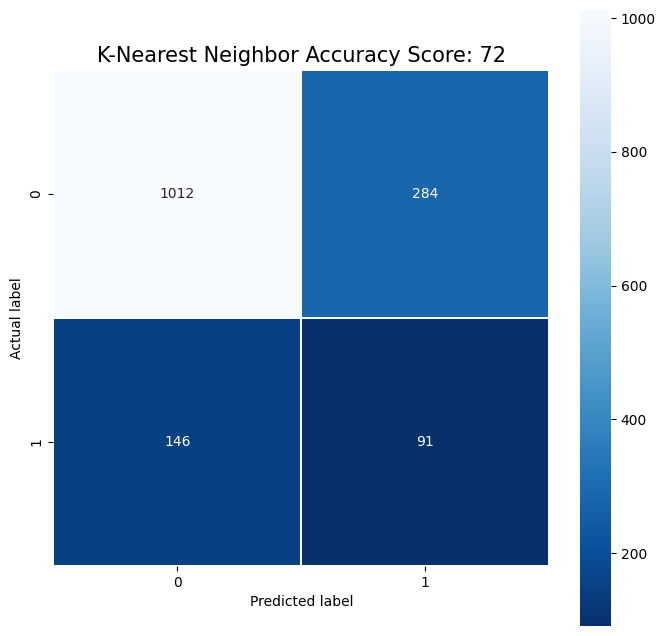

In [ ]:
cm_knn = metrics.confusion_matrix(Y_df_test,result_knn)

plt.figure(figsize=(8,8))
sns.heatmap(cm_knn, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'K-Nearest Neighbor Accuracy Score: {0}'.format(round(score_knn*100))
plt.title(title,size=15);

## Kiệt(Logistic Regression)

Logistic Regression

In [ ]:
start = time.time()
lr = LogisticRegression(random_state = 42)
poly_lr = PolynomialFeatures(degree = 1)
X_lr = poly_lr.fit_transform(X_train)
lr.fit(X_lr , Y_train)
end = time.time()

X_lr = poly_lr.fit_transform(X_test)
result_lr = lr.predict(X_lr)
score_lr = metrics.accuracy_score(Y_test,result_lr)        
print("Accruracy:",score_lr)
print("Report:\n",metrics.classification_report(Y_test,result_lr))

Accruracy: 0.6727467811158798
Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       535
           1       0.61      0.63      0.62       397

    accuracy                           0.67       932
   macro avg       0.67      0.67      0.67       932
weighted avg       0.67      0.67      0.67       932



In [ ]:
print('Thời gian thực thi với thuật toán Logistric Regression:', end - start)

Thời gian thực thi với thuật toán Logistric Regression: 0.03815150260925293


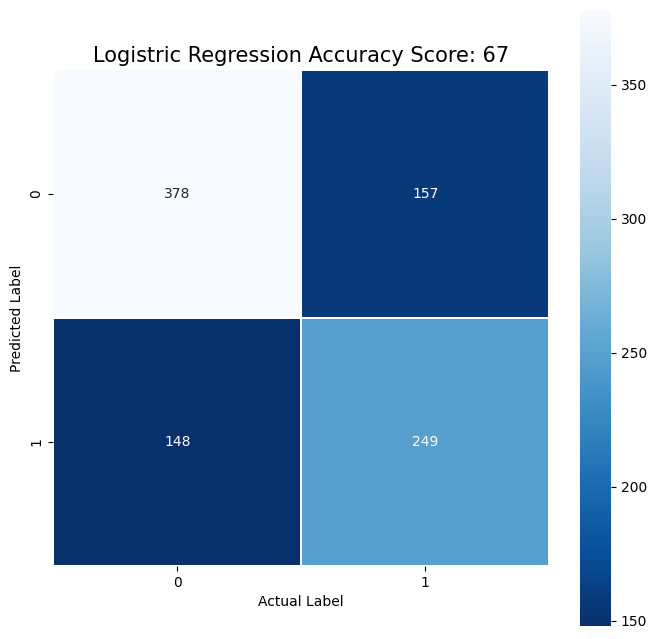

In [ ]:
lr_cm = metrics.confusion_matrix(Y_test,result_lr)
plt.figure(figsize=(8,8))
sns.heatmap(lr_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Logistric Regression Accuracy Score:{0}'.format(" "+str(round(score_lr*100)))
plt.title(title,size=15);

***df_test***

In [ ]:
X_lr = poly_lr.fit_transform(X_df_test)
result_lr = lr.predict(X_lr)
score_lr = metrics.accuracy_score(Y_df_test,result_lr)        
print('Accuracy score = {}'.format(score_lr))  
print("Report:\n",metrics.classification_report(Y_df_test,result_lr))

Accuracy score = 0.6001304631441617
Report:
               precision    recall  f1-score   support

           0       0.90      0.59      0.71      1296
           1       0.22      0.64      0.33       237

    accuracy                           0.60      1533
   macro avg       0.56      0.62      0.52      1533
weighted avg       0.80      0.60      0.66      1533



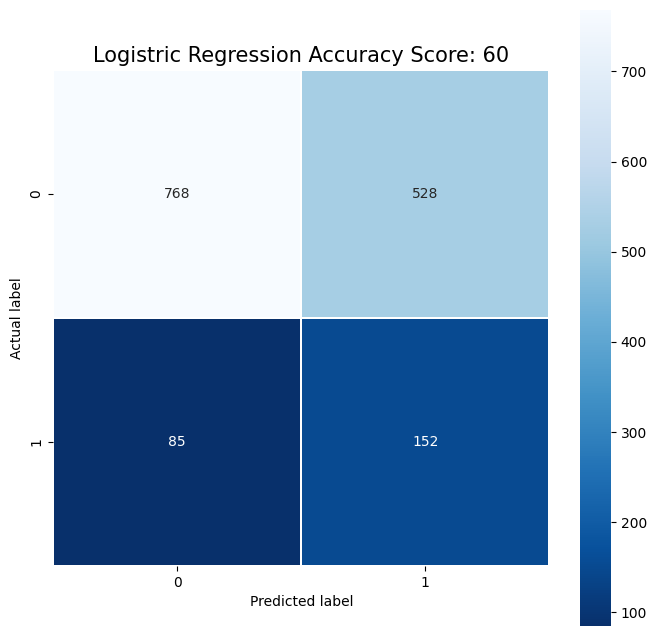

In [ ]:
cm_lr = metrics.confusion_matrix(Y_df_test,result_lr)

plt.figure(figsize=(8,8))
sns.heatmap(cm_lr, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Logistric Regression Accuracy Score: {0}'.format(round(score_lr*100))
plt.title(title,size=15);

## Lâm(SVM, Neural network)

* SVM

In [ ]:
start = time.time()
svm = SVC(kernel = 'rbf')
poly_svm = PolynomialFeatures(degree = 1)
X_svm = poly_svm.fit_transform(X_train)
svm.fit(X_svm , Y_train)
end = time.time()

X_svm = poly_svm.fit_transform(X_test)
result_svm = svm.predict(X_svm)
score_svm = metrics.accuracy_score(Y_test,result_svm)        
print("Accruracy:",score_svm)
print("Report:\n",metrics.classification_report(Y_test,result_svm))

Accruracy: 0.6512875536480687
Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69       535
           1       0.59      0.62      0.60       397

    accuracy                           0.65       932
   macro avg       0.65      0.65      0.65       932
weighted avg       0.65      0.65      0.65       932



In [ ]:
print('Thời gian thực thi với thuật toán SVM:', end - start)

Thời gian thực thi với thuật toán SVM: 0.3919672966003418


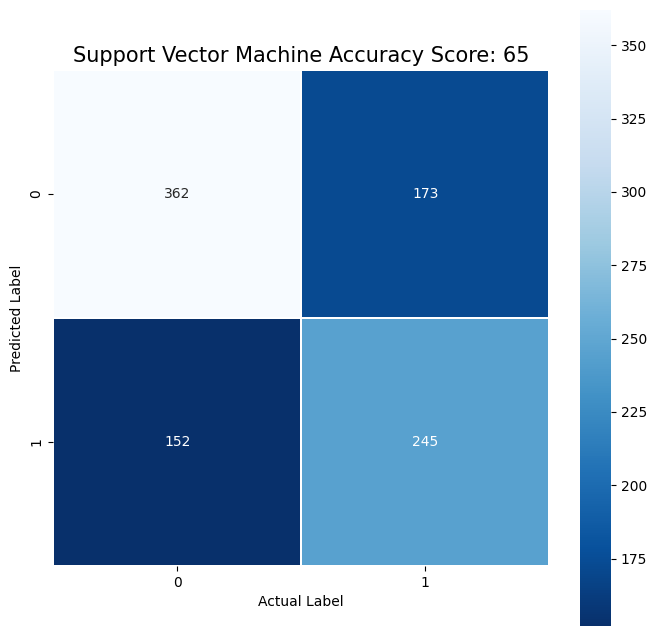

In [ ]:
svm_cm = metrics.confusion_matrix(Y_test,result_svm)
plt.figure(figsize=(8,8))
sns.heatmap(svm_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Support Vector Machine Accuracy Score:{0}'.format(" "+str(round(score_svm*100)))
plt.title(title,size=15);

***df_test***

In [ ]:
X_svm = poly_svm.fit_transform(X_df_test)
result_svm = svm.predict(X_svm)
score_svm = metrics.accuracy_score(Y_df_test,result_svm)        
print('Accuracy score = {}'.format(score_svm))  
print("Report:\n",metrics.classification_report(Y_df_test,result_svm))

Accuracy score = 0.5499021526418787
Report:
               precision    recall  f1-score   support

           0       0.88      0.54      0.67      1296
           1       0.19      0.60      0.29       237

    accuracy                           0.55      1533
   macro avg       0.54      0.57      0.48      1533
weighted avg       0.78      0.55      0.61      1533



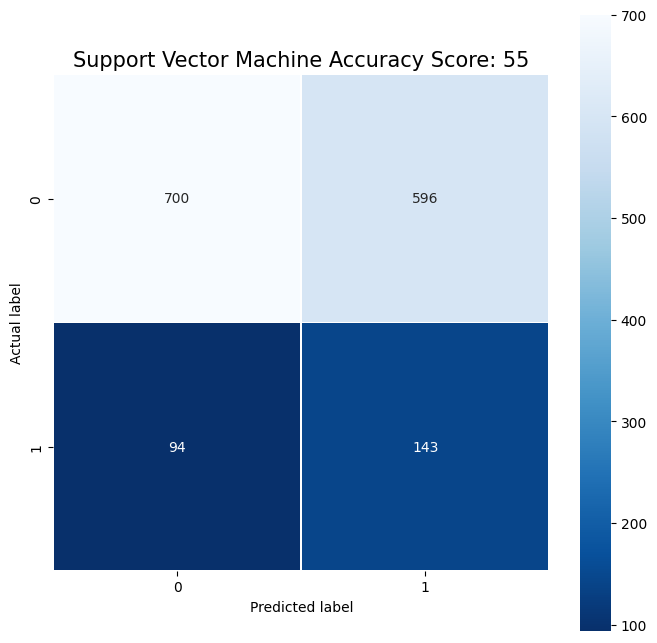

In [ ]:
cm_svm = metrics.confusion_matrix(Y_df_test,result_svm)

plt.figure(figsize=(8,8))
sns.heatmap(cm_svm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Support Vector Machine Accuracy Score: {0}'.format(round(score_svm*100))
plt.title(title,size=15);

* Neural network



In [ ]:
start = time.time()
nn = MLPClassifier()
poly_nn = PolynomialFeatures(degree = 1)
X_nn = poly_nn.fit_transform(X_train)
nn.fit(X_nn , Y_train)
end = time.time()

X_nn = poly_nn.fit_transform(X_test)
result_nn = nn.predict(X_nn)
score_nn = metrics.accuracy_score(Y_test,result_nn)        
print("Accruracy:",score_nn)
print("Report:\n",metrics.classification_report(Y_test,result_nn))

Accruracy: 0.6630901287553648
Report:
               precision    recall  f1-score   support

           0       0.73      0.66      0.69       535
           1       0.59      0.67      0.63       397

    accuracy                           0.66       932
   macro avg       0.66      0.66      0.66       932
weighted avg       0.67      0.66      0.66       932



In [ ]:
print('Thời gian thực thi với thuật toán KNN:', end - start)

Thời gian thực thi với thuật toán KNN: 4.34818172454834


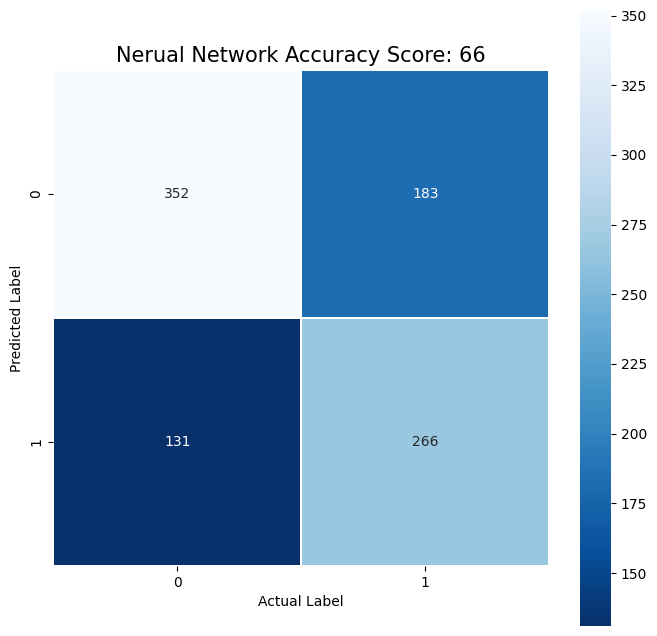

In [ ]:
nn_cm = metrics.confusion_matrix(Y_test,result_nn)
plt.figure(figsize=(8,8))
sns.heatmap(nn_cm,annot=True, fmt=".0f",linewidth=.5,square=True,cmap='Blues_r');
plt.xlabel('Actual Label');
plt.ylabel('Predicted Label');
title ='Nerual Network Accuracy Score:{0}'.format(" "+str(round(score_nn*100)))
plt.title(title,size=15);
plt.show();

***df_test***

In [ ]:
X_nn = poly_nn.fit_transform(X_df_test)
result_nn = nn.predict(X_nn)
score_nn = metrics.accuracy_score(Y_df_test,result_nn)        
print('Accuracy score = {}'.format(score_nn))  
print("Report:\n",metrics.classification_report(Y_df_test,result_nn))

Accuracy score = 0.5799086757990868
Report:
               precision    recall  f1-score   support

           0       0.90      0.57      0.69      1296
           1       0.22      0.66      0.33       237

    accuracy                           0.58      1533
   macro avg       0.56      0.61      0.51      1533
weighted avg       0.79      0.58      0.64      1533



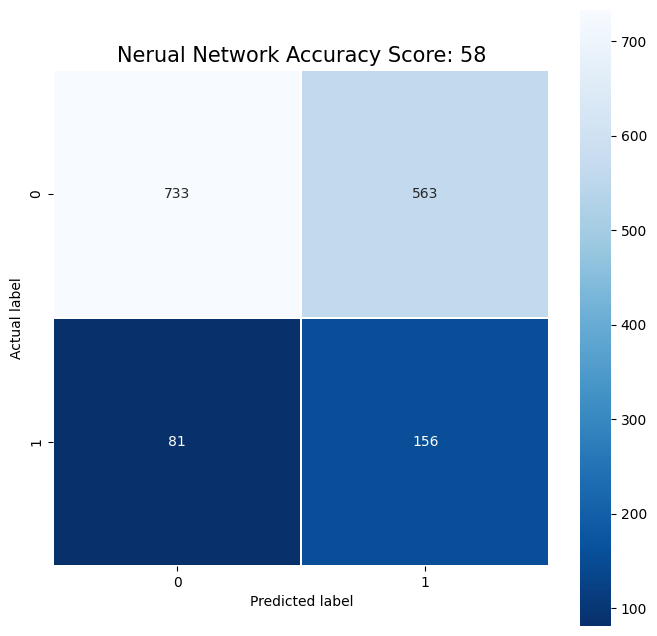

In [ ]:
cm_nn = metrics.confusion_matrix(Y_df_test,result_nn)

plt.figure(figsize=(8,8))
sns.heatmap(cm_nn, annot=True, fmt=".0f", linewidths=.5, square=True, cmap="Blues_r")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
title = 'Nerual Network Accuracy Score: {0}'.format(round(score_nn*100))
plt.title(title,size=15);